# **Forest Segmentation on Satellite and Aerial Images**

## **Motivation**

## **Problem**

## **Set Up**


#### Google drive



In [147]:
from google.colab import drive
import sys

# Mount Google Drive
drive.mount('/content/drive')

# Get the absolute path of the current folder
abspath_curr = '/content/drive/My Drive/Colab Notebooks/teaching/gwu/machine_learning_I/fall_2021/final_project'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Import Libraries

In [148]:
import warnings

import matplotlib.pyplot as plt
%matplotlib inline 

%tensorflow_version 2.x 
import tensorflow as tf
from tensorflow import keras

import numpy as np

import pandas as pd

import os
import shutil

from PIL import Image
import glob

import pickle

In [149]:
# Ignore warnings
warnings.filterwarnings('ignore')

In [150]:
# Set matplotlib sizes
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=20)
plt.rc('figure', titlesize=20)

In [151]:
# Random Seed

# The random seed
random_seed = 42

# Set random seed in tensorflow
tf.random.set_seed(random_seed)

# Set random seed in numpy
np.random.seed(random_seed)

In [152]:
# Check what version of TF we are using
print(tf.version.VERSION)

2.6.0


In [153]:
# Print the number of GPUs available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Test to see if GPU is found and connected
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('\nFound GPU at: {}'.format(device_name))

print('\nCurrently using:')
!nvidia-smi -L

Num GPUs Available:  0


SystemError: ignored

## **Data Pre-Processing**

### **Set Up Data**

Before we can load data, we need to rename our image and mask files to be the same name. This will ensure proper order and equivalent image and mask when we load.

In [154]:
def rename_data_files(path, rm):
  """
  Function to rename our images and their corresponding masks files to be the same.

  Parameters:
  path - filepath to image or mask data
  rm - string to remove and make image and corresponding mask file match

  Return:
  None
  """
  for count, filename in enumerate(os.listdir(path)):
    src = path + filename
    new_filename = filename.replace(rm, '')
    dst = path + new_filename
    
    os.rename(src, dst)

In [155]:
rename_data_files(abspath_curr + '/data/images/', 'sat_')

In [156]:
rename_data_files(abspath_curr + '/data/masks/', 'mask_')

Check if each satellite image filename has one equivalent filename in mask.

In [157]:
img_filenames = os.listdir(abspath_curr + '/data/images/')  
msk_filenames = os.listdir(abspath_curr + '/data/masks/')

if True in list(map(lambda x : True if x in msk_filenames else False, img_filenames)):
  print('Images in Masks matches.')
else:
  print('Not matching Images in Masks, double check filenames.')

if True in list(map(lambda x : True if x in img_filenames else False, msk_filenames)):
  print('Masks in Images matches.')
else:
  print('Not matching Masks in Images, double check filenames.')

Images in Masks matches.
Masks in Images matches.


### **Initial Inspection of Data**

In [158]:
images = tf.keras.preprocessing.image_dataset_from_directory(
    directory = abspath_curr + '/data/images',
    labels = None,
    label_mode = None,
    color_mode = "rgb",
    batch_size = 1,
    image_size = (256, 256),
    shuffle = False,
    seed = random_seed
)
images = images.unbatch()

Found 5108 files belonging to 1 classes.


In [159]:
masks = tf.keras.preprocessing.image_dataset_from_directory(
    directory = abspath_curr + '/data/masks',
    labels = None,
    label_mode = None,
    color_mode = "rgb",
    batch_size = 1,
    image_size = (256, 256),
    shuffle = False,
    seed = random_seed
)
masks = masks.unbatch()

Found 5108 files belonging to 1 classes.


In [160]:
imgs = images.take(9)
imgs_lst = list(imgs.as_numpy_iterator())
print(imgs_lst[0].shape)

(256, 256, 3)


In [161]:
msks = masks.take(9)
msks_lst = list(msks.as_numpy_iterator())
print(msks_lst[0].shape)

(256, 256, 3)


In [162]:
def show_images(images, masks, n):
  '''
  Plots first n sample images from list of images

  Parameters:

  Return
  None, plots images
  '''
  plt.figure(figsize=(1, 1))
  fig, axs = plt.subplots(n, 2)

  for i in range(n):
    img = images[i]
    label = masks[i]
    axs[i, 0].imshow(img.astype('uint8'))
    axs[i, 0].set_title('Original', fontdict = {'fontsize' : 8})
    axs[i, 0].axis("off")

    axs[i, 1].imshow(label.astype('uint8'))
    axs[i, 1].set_title('Mask', fontdict = {'fontsize' : 8})
    axs[i, 1].axis("off")

  plt.show()

<Figure size 72x72 with 0 Axes>

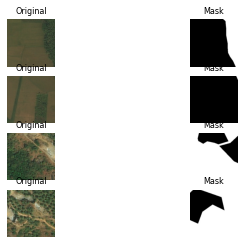

In [163]:
show_images(imgs_lst, msks_lst, 4)

### **Split Train, Val, Test**

In [164]:
df = pd.read_csv(abspath_curr + "/data/meta_data.csv")

df.head()

,image,mask
0,10452_sat_08.jpg,10452_mask_08.jpg
1,10452_sat_18.jpg,10452_mask_18.jpg
2,111335_sat_00.jpg,111335_mask_00.jpg
3,111335_sat_01.jpg,111335_mask_01.jpg
4,111335_sat_02.jpg,111335_mask_02.jpg


In [165]:
# Replace sat_ and maks_ in filenames
df['image'] = df['image'].str.replace('sat_', '')
df['mask'] = df['mask'].str.replace('mask_', '')
df.head()

,image,mask
0,10452_08.jpg,10452_08.jpg
1,10452_18.jpg,10452_18.jpg
2,111335_00.jpg,111335_00.jpg
3,111335_01.jpg,111335_01.jpg
4,111335_02.jpg,111335_02.jpg


In [166]:
# Create divides for train, test, val
train_num_samples = round(len(df)*0.8)
test_num_samples = round((len(df) - train_num_samples)/2)
val_num_samples = len(df) - test_num_samples - train_num_samples

In [167]:
#shuffle all rows of DataFrame
df = df.sample(frac=1, random_state=random_seed).reset_index(drop=True)
df.head()

,image,mask
0,749375_84.jpg,749375_84.jpg
1,299287_22.jpg,299287_22.jpg
2,296279_80.jpg,296279_80.jpg
3,876248_28.jpg,876248_28.jpg
4,192918_76.jpg,192918_76.jpg


In [168]:
df['data_split'] = ''
df['data_split'].iloc[:train_num_samples] = 'train'
df['data_split'].iloc[train_num_samples:train_num_samples+val_num_samples] = 'val'
df['data_split'].iloc[train_num_samples+val_num_samples:] = 'test'

print('Samples in train: ', len(df[df['data_split'] == 'train']))
print('Samples in validation: ', len(df[df['data_split'] == 'val']))
print('Samples in test: ', len(df[df['data_split'] == 'test']))
df.head()

Samples in train:  4086
Samples in validation:  511
Samples in test:  511


,image,mask,data_split
0,749375_84.jpg,749375_84.jpg,train
1,299287_22.jpg,299287_22.jpg,train
2,296279_80.jpg,296279_80.jpg,train
3,876248_28.jpg,876248_28.jpg,train
4,192918_76.jpg,192918_76.jpg,train


In [169]:
def make_directory(path):
  """
  Function to make directory if not exits

  Paramater:
  path - path of directory

  Return:
  None
  """
  directory = os.path.dirname(path)
  if not os.path.exists(directory):
    os.makedirs(directory)
  
  return


In [199]:
# Make directories
make_directory(abspath_curr + '/data/train_test_split/train/images/')
make_directory(abspath_curr + '/data/train_test_split/train/masks/')

make_directory(abspath_curr + '/data/train_test_split/val/images/')
make_directory(abspath_curr + '/data/train_test_split/val/masks/')

make_directory(abspath_curr + '/data/train_test_split/test/images/')
make_directory(abspath_curr + '/data/train_test_split/test/masks/')

In [171]:
def move_files(list_filenames, source_path, target_path):
  """
  Function to move files from source to target directory based on a list of filenames within source

  Parameters:
  list_filesname - list of filenames
  source_path - path of source directory
  target_path - path of target directory

  Return:
  None
  """
  for file_name in list_filenames:
      try:
        shutil.move(os.path.join(source_path, file_name), os.path.join(target_path, file_name))
      except FileNotFoundError:
        continue

In [172]:
# List of test, val, train filenames
test_files_list = list(df[df['data_split'] == 'test']['image'])
val_files_list = list(df[df['data_split'] == 'val']['image'])
train_files_list = list(df[df['data_split'] == 'train']['image'])

In [174]:
# Moves files to train, val, test directories

# Train
move_files(train_files_list, abspath_curr + '/data/images', abspath_curr + '/data/train_test_split/train/images')
move_files(train_files_list, abspath_curr + '/data/masks', abspath_curr + '/data/train_test_split/train/masks')

# Val
move_files(val_files_list, abspath_curr + '/data/images', abspath_curr + '/data/train_test_split/val/images')
move_files(val_files_list, abspath_curr + '/data/masks', abspath_curr + '/data/train_test_split/val/masks')

# Test
move_files(test_files_list, abspath_curr + '/data/images', abspath_curr + '/data/train_test_split/test/images')
move_files(test_files_list, abspath_curr + '/data/masks', abspath_curr + '/data/train_test_split/test/masks')

In [206]:
# Check if images got moved right
print('Train Images: ', len(os.listdir(abspath_curr + '/data/train_test_split/train/images')))
print('Train Masks: ',len(os.listdir(abspath_curr + '/data/train_test_split/train/masks')))

print('Val Images: ',len(os.listdir(abspath_curr + '/data/train_test_split/val/images')))
print('Val Masks: ',len(os.listdir(abspath_curr + '/data/train_test_split/val/masks')))

print('Test Images: ',len(os.listdir(abspath_curr + '/data/train_test_split/test/images')))
print('Test Masks: ',len(os.listdir(abspath_curr + '/data/train_test_split/test/masks')))

Train Images:  4086
Train Masks:  4086
Val Images:  511
Val Masks:  511
Test Images:  511
Test Masks:  511


### **Load Data**

**Set up generators and loading data to generators**

In [207]:
# Create two instances of ImageDataGenerator with same arguments
data_gen_args = dict(
                     rotation_range=90,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2,
                     rescale=1./255
                     )

image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)
mask_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)

In [ ]:
# Provide the same seed and keyword arguments to the fit and flow methods

# Fit
# image_datagen.fit(images, augment=True, seed=random_seed)
# mask_datagen.fit(masks, augment=True, seed=random_seed)

In [208]:
# Flow

# Train
image_train_generator = image_datagen.flow_from_directory(
    directory = abspath_curr + '/data/train_test_split/train/',
    target_size=(256, 256),
    color_mode='rgb',
    classes=None,
    class_mode=['images'],
    batch_size=32, 
    shuffle=False,
    seed=random_seed)

mask_train_generator = mask_datagen.flow_from_directory(
    abspath_curr + '/data/train_test_split/train/',
    target_size=(256, 256),
    color_mode='rgb',
    classes=None,
    class_mode=['masks'],
    batch_size=32, 
    shuffle=False,
    seed=random_seed)

# Val
image_val_generator = image_datagen.flow_from_directory(
    abspath_curr + '/data/train_test_split/val/',
    target_size=(256, 256),
    color_mode='rgb',
    classes=None,
    class_mode=['images'],
    batch_size=32, 
    shuffle=False,
    seed=random_seed)

mask_val_generator = mask_datagen.flow_from_directory(
    abspath_curr + '/data/train_test_split/val/',
    target_size=(256, 256),
    color_mode='rgb',
    classes=None,
    class_mode=['masks'],
    batch_size=32, 
    shuffle=False,
    seed=random_seed)

# Test
image_test_generator = image_datagen.flow_from_directory(
    abspath_curr + '/data/train_test_split/test/',
    target_size=(256, 256),
    color_mode='rgb',
    classes=None,
    class_mode=['images'],
    batch_size=32, 
    shuffle=False,
    seed=random_seed)

mask_test_generator = mask_datagen.flow_from_directory(
    abspath_curr + '/data/train_test_split/test/',
    target_size=(256, 256),
    color_mode='rgb',
    classes=None,
    class_mode=['masks'],
    batch_size=32, 
    shuffle=False,
    seed=random_seed)

Found 4086 images belonging to 1 classes.
Found 4086 images belonging to 1 classes.
Found 511 images belonging to 1 classes.
Found 511 images belonging to 1 classes.
Found 511 images belonging to 1 classes.
Found 511 images belonging to 2 classes.


In [ ]:
# Combine train and val generators into one which yields image and masks.
# Keep image and masks for tests separate for prediction.

train_generator = zip(image_train_generator, mask_train_generator)
val_generator = zip(image_val_generator, mask_val_generator)

## **Build Model(s)**

### **FCN**

### **U-Net**

### **Mask R-CNN**

In [ ]:
# model.fit(
#     train_generator,
#     steps_per_epoch=2000,
#     epochs=50)

In [81]:
# def image_mask_generator(image_data_generator, mask_data_generator):
#   """
#   Function to generate and zip image_mask_generator from separate image and mask generators.

#   Parameters:
#   image_data_generator - 
#   mask_data_generator - 

#   Return:
#   Yields img, mask
#   """
#   train_generator = zip(image_data_generator, mask_data_generator)
#   for (img, mask) in train_generator:
#     yield (img, mask)

In [87]:
# image_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
#     width_shift_range = 0.1,
#     height_shift_range = 0.1,
#     rotation_range = 10,
#     zoom_range = 0.1
# ).flow_from_directory(abspath_curr + '/data/images/', batch_size = 32, target_size = (256, 256), seed = random_seed)

# mask_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
#     width_shift_range = 0.1,
#     height_shift_range = 0.1,
#     rotation_range = 10,
#     zoom_range = 0.1
# ).flow_from_directory(abspath_curr + '/data/masks/', batch_size = 32, target_size = (256, 256), seed = random_seed)

Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.


In [ ]:
# my_generator = my_image_mask_generator(image_data_generator, mask_data_generator)


## **Train**

## **Conclusion**

## **Citations**

- https://stackoverflow.com/questions/56517963/keras-imagedatagenerator-for-segmentation-with-images-and-masks-in-separate-dire
- https://tensorflow.google.cn/api_docs/python/tf/data/Dataset?hl=zh-cn#take
- https://keras.io/api/preprocessing/image/
- https://awaywithideas.com/a-simple-example-of-semantic-segmentation-with-tensorflow-keras/
- https://github.com/kevinddchen/Keras-FCN
- https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
- https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/
- https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2
- https://keras.io/api/metrics/segmentation_metrics/
- https://datascience.stackexchange.com/questions/68888/how-to-use-keras-predict-generator-for-segmentation-output


In [80]:
# plt.imshow(images_data_lst[0].astype('uint8'))